In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import  layers , models ,optimizers
from tensorflow import  keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils import shuffle
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
import imgaug.augmenters as iaa

In [2]:
dataset_path = '/content/drive/MyDrive/Smoking Image Detection with CNN/Image Dataset/Training'
img_size = 250

train_data = []
train_labels = []
train_paths = []

# Iterate through the dataset directory
for img_name in os.listdir(dataset_path):

    if(img_name[:3] == 'not'):
      img_class = 'notsmoking'
    else :
      img_class = 'smoking'
    train_labels.append(img_class)
    img_path = os.path.join(dataset_path, img_name)
    train_paths.append(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    train_data.append([img,img_class])

In [3]:
dataset_path = '/content/drive/MyDrive/Smoking Image Detection with CNN/Image Dataset/Testing'

test_data = []
test_labels = []
test_paths = []
# Iterate through the dataset directory
for img_name in os.listdir(dataset_path):
    if(img_name[:3] == 'not'):
      img_class = 'notsmoking'
    else :
      img_class = 'smoking'
    test_labels.append(img_class)
    img_path = os.path.join(dataset_path, img_name)
    test_paths.append(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_data.append([img,img_class])

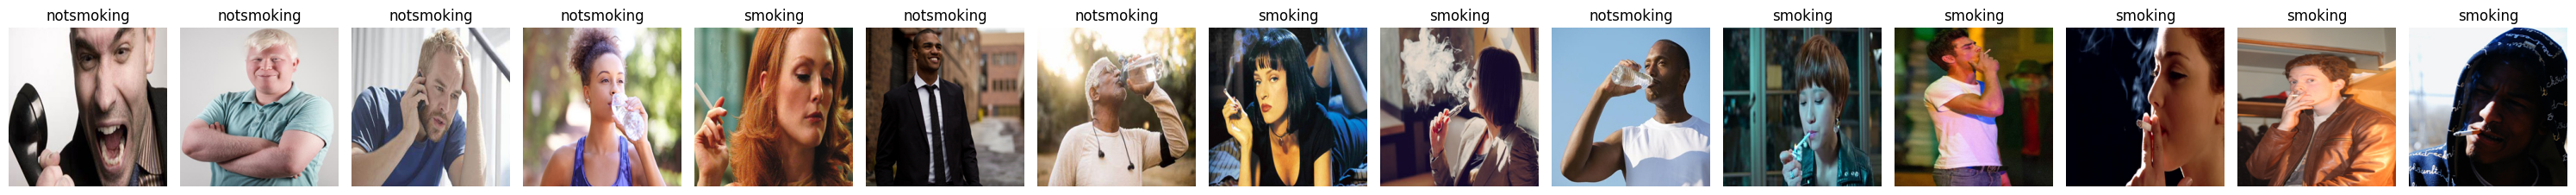

In [4]:
def display_random_images(images, labels, num_images=15):
    num_total_images = len(images)
    random_indices = np.random.choice(num_total_images, size=num_images, replace=False)

    fig, axes = plt.subplots(1, num_images, figsize=(30, 5))
    for i, idx in enumerate(random_indices):
        axes[i].imshow(images[idx][0])

        axes[i].set_title(labels[idx])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

display_random_images(train_data, train_labels)

In [5]:
random.shuffle(train_data)
random.shuffle(test_data)

In [6]:
x_train , x_test , y_train , y_test = [] , [] , [] , []

def extract_splits(data):
    for features ,label  in data  :

        if(data == train_data):
            x_train.append(features)
            y_train.append(label)
        else:
            x_test.append(features)
            y_test.append(label)

In [7]:
extract_splits(train_data)

In [8]:
extract_splits(test_data)

In [9]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [10]:
print("x_train shape ",x_train.shape)
print("y_train shape ",y_train.shape)

print("x_train shape ",x_test.shape)
print("y_train shape ",y_test.shape)

x_train shape  (716, 250, 250, 3)
y_train shape  (716,)
x_train shape  (224, 250, 250, 3)
y_train shape  (224,)


In [11]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [12]:
def display_seq_images(images, labels, num_images=5):
    num_total_images = len(images)

    fig, axes = plt.subplots(1, num_images, figsize=(30, 5))
    for i, idx in enumerate(range(num_images)):
        axes[i].imshow(images[idx], aspect='auto')

        axes[i].set_title(labels[idx])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [13]:
def augment_images(images, labels, num_augmentations=4):
    augmented_images = []
    augmented_labels = []

    # Define augmentation sequence
    seq = iaa.Sequential([
        iaa.Fliplr(1.0),  # Horizontal flip with 100% probability
        iaa.Multiply((1.5, 2.5), per_channel=0.5)  # Adjust saturation
    ])

    # Apply augmentation to each image
    for original_image, label in zip(images, labels):
        augmented_images.append(original_image)  # Add original image
        augmented_labels.append(label)

        # Apply augmentation to create additional augmented images
        augmented_images.extend(seq(images=[original_image] * (num_augmentations)))
        augmented_labels.extend([label] * (num_augmentations))

    return np.array(augmented_images), np.array(augmented_labels)

num_augmentations = 4

# Apply augmentation to the entire training dataset
augmented_images,augmented_labels = augment_images(x_train,y_train_encoded ,num_augmentations)

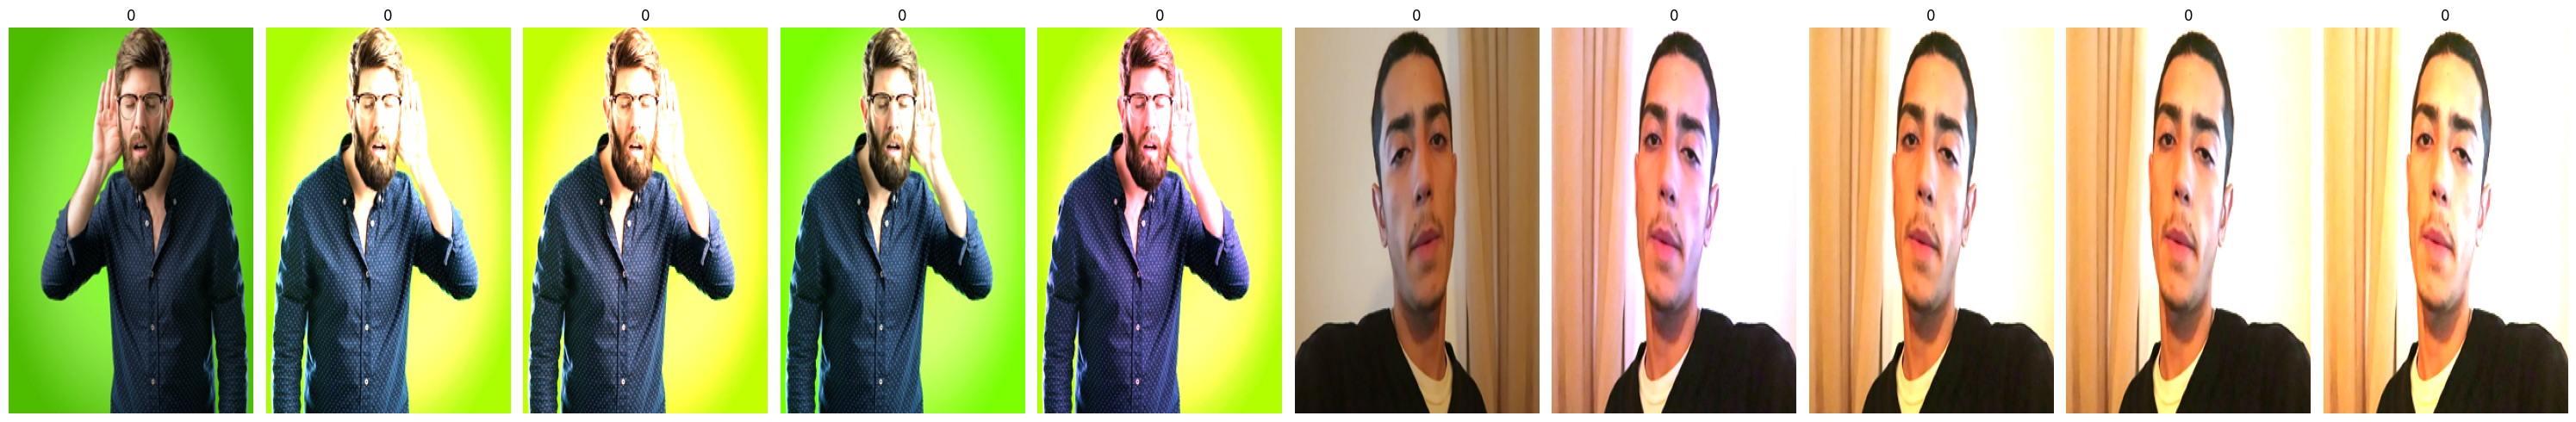

In [14]:
display_seq_images(augmented_images,augmented_labels,10)

In [15]:
preprocess_input = keras.applications.resnet50.preprocess_input

In [16]:
img_shape = augmented_images[0].shape
base_model = keras.applications.ResNet50(
    input_shape=img_shape,
    include_top=False,
    weights="imagenet",

)

94765736/94765736 [==============================] - 1s 0us/step


In [17]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 125, 125, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 125, 125, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [18]:
# Build the model on top of the pre-trained base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # Use 'softmax' activation for multi-class classification
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
              metrics=['accuracy'])

In [19]:
# Train the model with batches
history = model.fit(augmented_images, augmented_labels, epochs=10, batch_size=64, validation_data=(x_test, y_test_encoded))

Epoch 1/10
56/56 [==============================] - 33s 352ms/step - loss: 0.9242 - accuracy: 0.6413 - val_loss: 0.4169 - val_accuracy: 0.8170
Epoch 2/10
56/56 [==============================] - 13s 226ms/step - loss: 0.6734 - accuracy: 0.7296 - val_loss: 0.3591 - val_accuracy: 0.8438
Epoch 3/10
56/56 [==============================] - 13s 230ms/step - loss: 0.5705 - accuracy: 0.7567 - val_loss: 0.3449 - val_accuracy: 0.8616
Epoch 4/10
56/56 [==============================] - 14s 243ms/step - loss: 0.5044 - accuracy: 0.7737 - val_loss: 0.3553 - val_accuracy: 0.8705
Epoch 5/10
56/56 [==============================] - 14s 245ms/step - loss: 0.4748 - accuracy: 0.7930 - val_loss: 0.3410 - val_accuracy: 0.8884
Epoch 6/10
56/56 [==============================] - 13s 237ms/step - loss: 0.4563 - accuracy: 0.7913 - val_loss: 0.3353 - val_accuracy: 0.8929
Epoch 7/10
56/56 [==============================] - 14s 250ms/step - loss: 0.4216 - accuracy: 0.8089 - val_loss: 0.3237 - val_accuracy: 0.8973

In [20]:
result = model.evaluate(x_test, y_test_encoded)

print("Accuracy Score: ", result[1]*100)

7/7 [==============================] - 1s 112ms/step - loss: 0.3237 - accuracy: 0.8929
Accuracy Score:  89.28571343421936


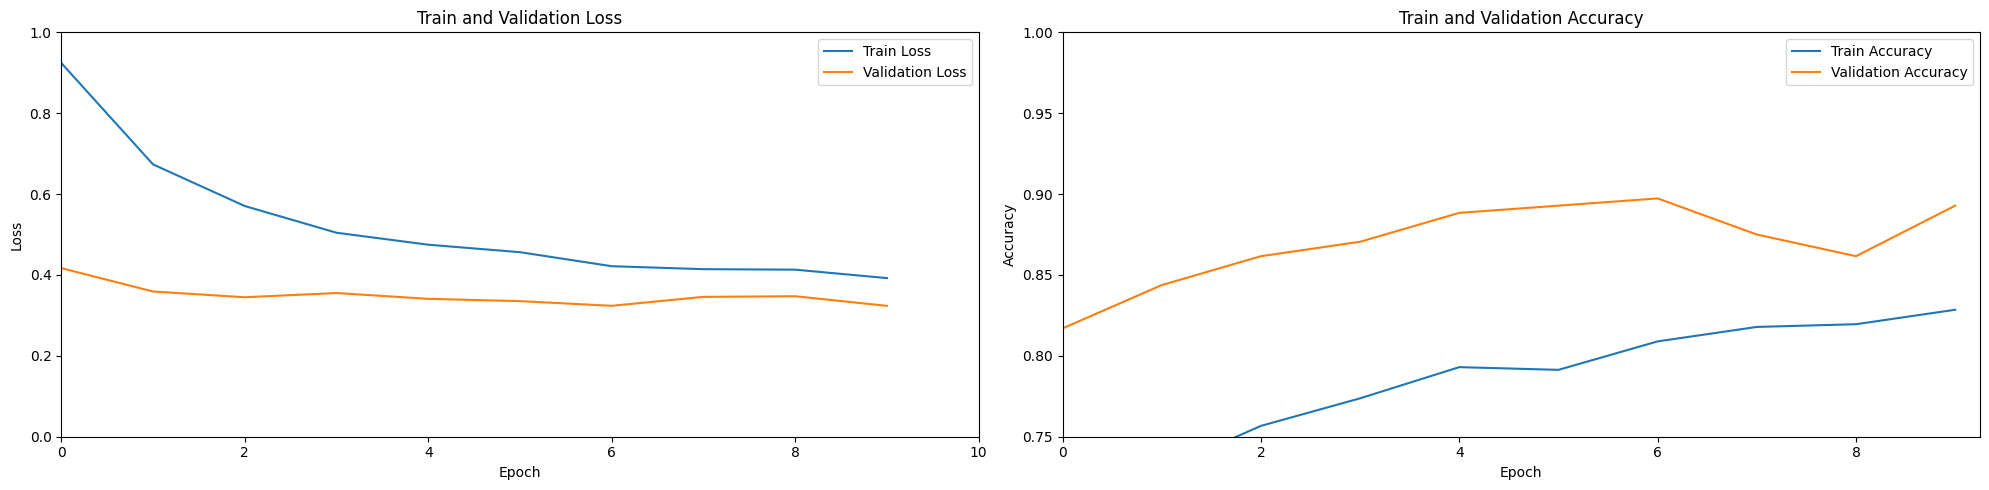

In [21]:
# Plotting loss and accuracy comparison

plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [22]:
# Making Prediction

y_pred=np.argmax(model.predict(x_test), axis=-1)
y_pred

7/7 [==============================] - 2s 116ms/step


array([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1])

In [23]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

print("Accuracy Score   : {:.2f} %".format(accuracy_score(y_test_encoded,y_pred) * 100))
print("Precision Score : {:.2f} %".format(precision_score(y_test_encoded,y_pred) * 100))
print("Recall Score    : {:.2f} %".format(recall_score(y_test_encoded,y_pred) * 100))
print("F1 Score    : {:.2f} %".format(f1_score(y_test_encoded,y_pred) * 100))
print("AUC Score    : {:.2f} %".format(roc_auc_score(y_test_encoded,y_pred) * 100))

Accuracy Score   : 89.29 %
Precision Score : 85.48 %
Recall Score    : 94.64 %
F1 Score    : 89.83 %
AUC Score    : 89.29 %


In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test_encoded,y_pred)
cm

array([[ 94,  18],
       [  6, 106]])

<Axes: >

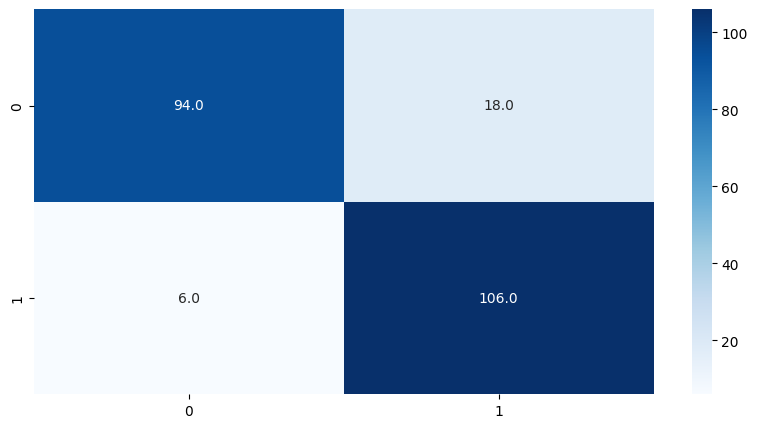

In [29]:
import seaborn as sns
plt.figure(figsize=(10, 5))

sns.heatmap(cm,annot=True, fmt=".1f", cmap="Blues")